# Pangolin is a <strike>powerful</strike>, <strike>efficient</strike>, <strike>large-scale</strike>, <strike>distributed</strike>, <strike>general</strike>, <strike>well-documented</strike>, <strike>well-tested</strike>, <strike>reliable</strike>, <strike>bug-free</strike>, fun interface for probabilistic reasoning

  or -

# Pangolin is "probabilistic programming that feels like numpy"

In [3]:
%load_ext autoreload
%autoreload 2

from pangolin import d, t, Given, I, IID, vmap, recurse, scan, sample, E, P, var, std, cov, corr, jags_code, makerv
from matplotlib import pyplot as plt
import numpy as np
np.set_printoptions(formatter={'float': '{:6.2f}'.format}) # print nicely#
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


There's a rule for this notebook: Each cell (except for the above imports) is totally independent.

# Sampling with scalars

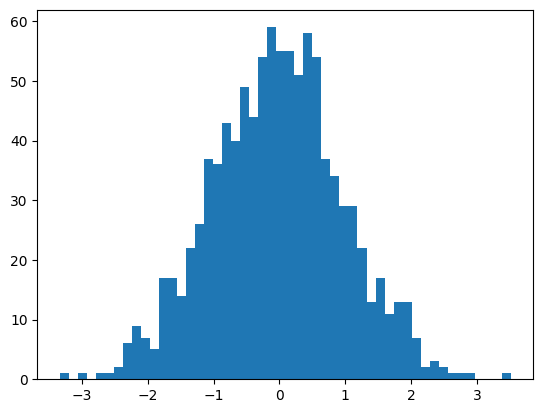

In [4]:
# draw samples from a Normal
x = d.norm(0,1)
xs = sample(x)
plt.hist(xs,50);

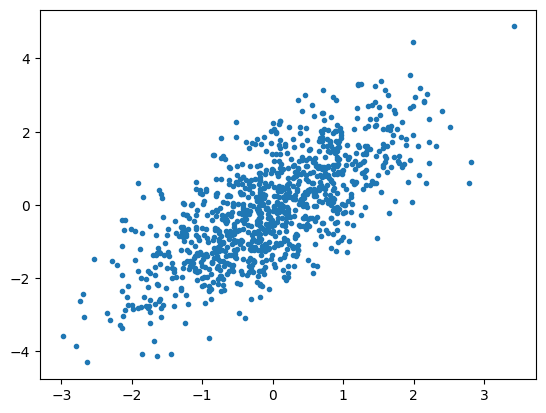

In [5]:
# draw samples from dependent Normals
x = d.norm(0,1)
y = d.norm(x,1)
xs, ys = sample([x,y])
plt.plot(xs,ys,'.');

In [6]:
# you can look at the JAGS code you generate
print(jags_code([x,y]))

model{
v5v~dnorm(v3v,v4v);
v7v~dnorm(v5v,v6v);
}



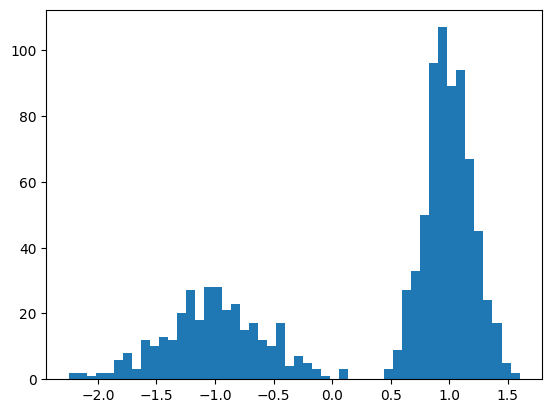

In [7]:
# mixture of normals
x = d.normmix([-1,1],[5,25],[.333,.667])
plt.hist(sample(x),50);
# JAGS actually loads a special module to handle this distribution

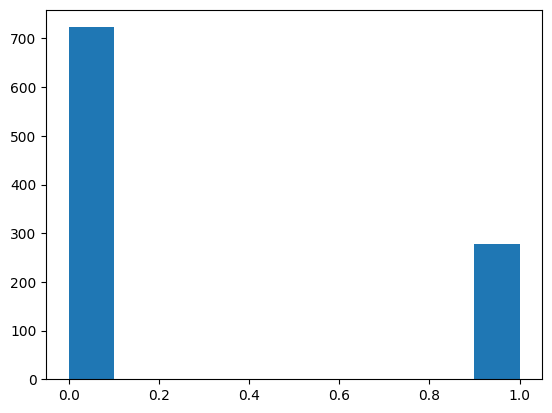

In [8]:
# Bernoulli
x = d.bern(0.25)
xs = sample(x)
plt.hist(xs);

In [9]:
# Dependent Bernoullis
x = d.bern(0.5)
y = d.bern(t.ifelse(x==0,0.25,0.75))
xs,ys = sample([x,y])
print('prob x==0',np.mean(xs==0))
print('prob y==0',np.mean(ys==0))
print('prob x==y',np.mean(xs==ys))

prob x==0 0.467
prob y==0 0.5
prob x==y 0.725


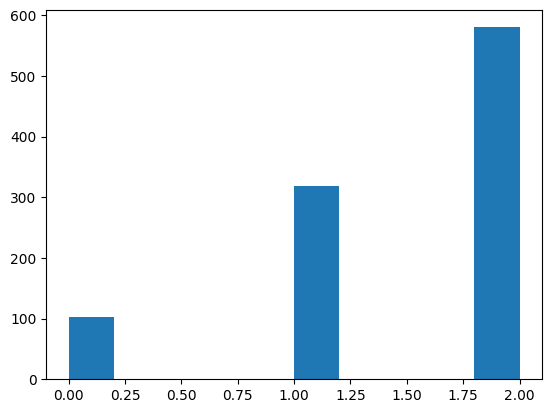

In [10]:
# categorical
x = d.cat([.1,.3,.6])
plt.hist(sample(x));

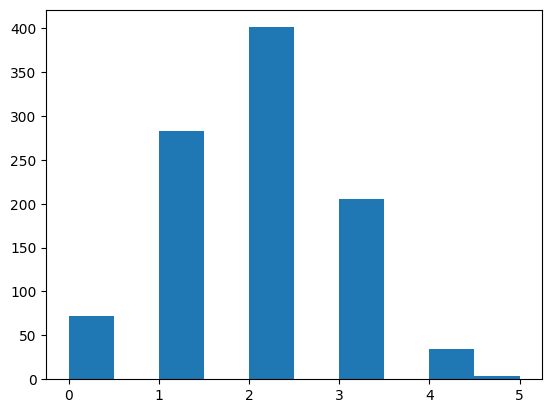

In [11]:
# hypergeometric
x = d.hyper(10,10,5,.5)
xs = sample(x)
plt.hist(xs);

In [12]:
# if you try to use wrong inputs, pangolin tries to warn you
print("expected to fail")
try:
    x = d.cat(2)
except Exception as e:
    print('error:',e)
    
print("expected to fail")
try:
    x = d.norm(1,[2,3])
except Exception as e:
    print('error:',e)

expected to fail
error: categorical takes 1-D vector input
expected to fail


# Sampling with scalars with observations

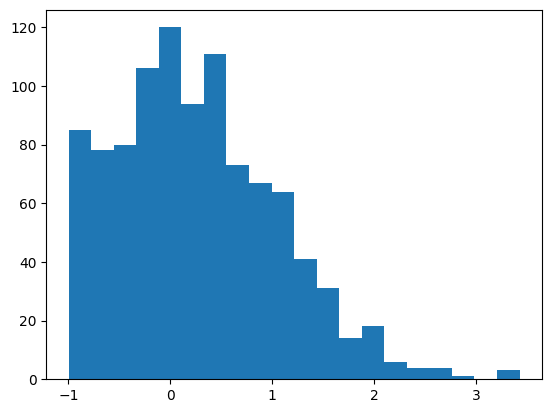

In [13]:
# drawing samples from a Normal with observations
x = d.norm(0,1)
xs = sample(x,Given(x>=-1))
plt.hist(xs,20);

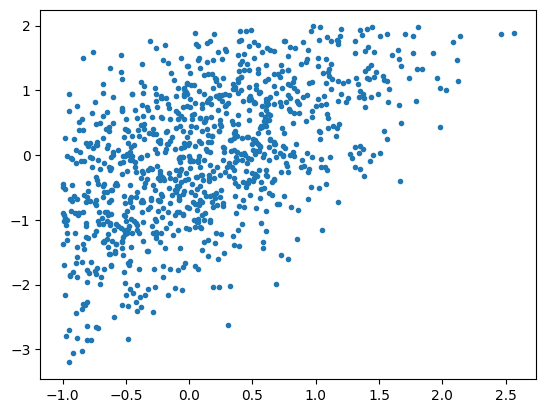

In [14]:
# draw samples from dependent Normals with observations
x = d.norm(0,1)
y = d.norm(x,1)
xs, ys = sample([x,y],Given(x>=-1,y<=2))
plt.plot(xs,ys,'.');

In [15]:
# Dependent Bernoullis
x = d.bern(0.75)                   # x usually 1
y = d.bern(t.ifelse(x==0,0.1,0.9)) # y almost always equal to x
xs = sample(x,Given(y==0))         # so what if y==0?
np.mean(xs)

0.23

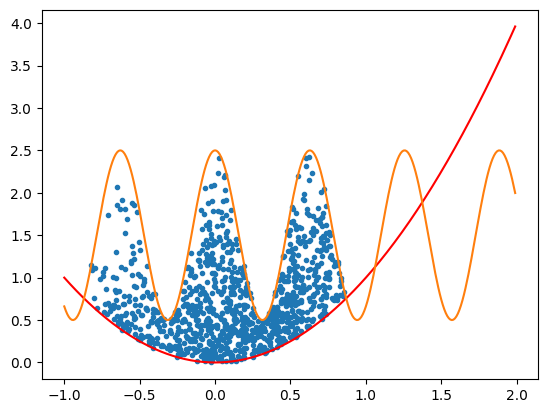

In [16]:
# you can use rather crazy inequality constraints

x = d.norm(0,1)
y = d.norm(x,1)
xs, ys = sample([x,y],Given(y>=x**2, y <= 1.5+t.cos(10*x)),init={y:1,x:0})
plt.plot(xs,ys,'.');
x = np.arange(-1,2,.01)
plt.plot(x,x**2,'r-')
plt.plot(x,1.5+np.cos(10*x));

# Quantiles and CDFs

In [17]:
x = d.t(0,5,1)
y = x.cdf(1)
ys = sample(y)
ys[:5]

array([  0.87,   0.87,   0.87,   0.87,   0.87])

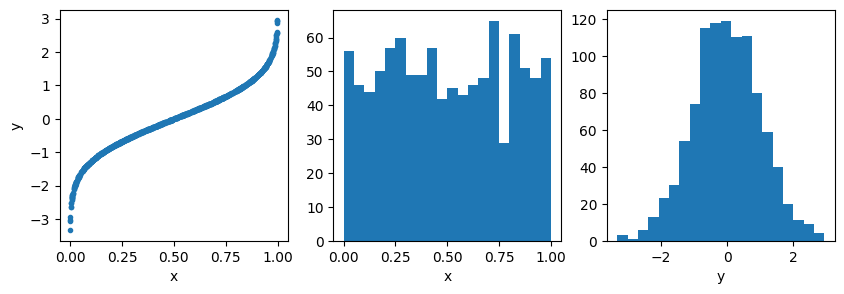

In [18]:
# you can use the quantile to transform the uniform distribution
# into whatever (only for scalar distributions)
x = d.unif(0,1)
y = d.norm(0,1).quantile(x)
xs,ys = sample([x,y])
plt.figure(figsize=(10,3))
plt.subplot(1,3,1); plt.plot(xs,ys,'.'); plt.xlabel('x'); plt.ylabel('y');
plt.subplot(1,3,2); plt.hist(xs,20); plt.xlabel('x');
plt.subplot(1,3,3); plt.hist(ys,20); plt.xlabel('y');

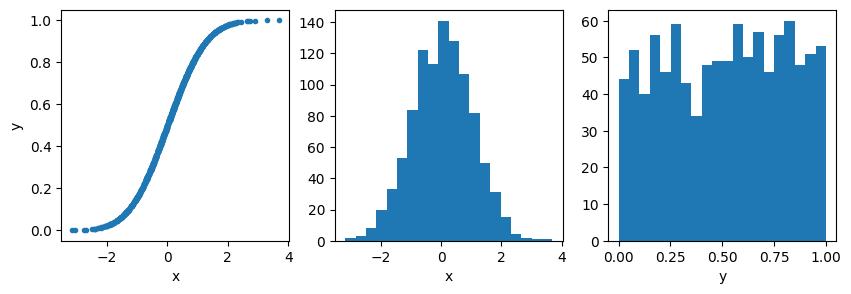

In [19]:
# or you can use CDFs to transform whatever into uniform
x = d.norm(0,1)
y = d.norm(0,1).cdf(x)
xs,ys = sample([x,y])
plt.figure(figsize=(10,3))
plt.subplot(1,3,1); plt.plot(xs,ys,'.'); plt.xlabel('x'); plt.ylabel('y');
plt.subplot(1,3,2); plt.hist(xs,20); plt.xlabel('x');
plt.subplot(1,3,3); plt.hist(ys,20); plt.xlabel('y');

# Gotchas for observations

In [20]:
# FIRST GOTCHA: Sometimes observations don't work by default

x = d.norm(0,1)
y = d.norm(x,1)
print('This is expected to fail:')
try:
    xs, ys = sample([x,y],Given(y>=x**2))
except Exception as e:
    print('error:',e)

This is expected to fail:
error: JAGS gave 'Node inconsistent with parents' error. Often this is resolved by providing initial values


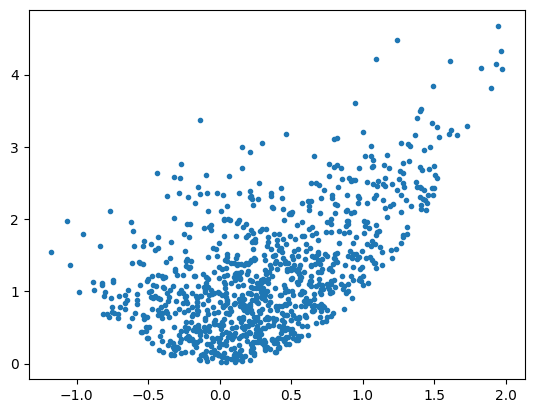

In [21]:
# You need to provide initial values so JAGS can start sampling

x = d.norm(0,1)
y = d.norm(x,1)
xs, ys = sample([x,y],Given(y>=x**2),init={y:1,x:0})
plt.plot(xs,ys,'.');

In [22]:
# SECOND GOTCHA
# can't condition on equalities on transformed random variables
# This is due to a limitation in JAGS
x = d.norm(0,1)
y = d.norm(x,1)
print('Expected to fail:')
try:
    xs, ys = sample([x,y],Given(y**2==1))
except Exception as e:
    print('error:',e)
    
# Note that (as we saw before) this _does_ work with an inequality

Expected to fail:
error: trying to condition non-conditionable variable: <class 'pangolin.ScalarDeterministic'>


In [23]:
# THIRD GOTCHA: Can't condition on random variables being equal to each other
# This is due to a limitation in JAGS
x = d.bern(0.5)
y = d.bern(t.ifelse(x==0,0.1,0.9))
z = d.bern(t.ifelse(y==0,0.1,0.9))
print("Expected to fail:")
try:
    E(y,Given(x==z))
except Exception as e:
    print('error:',e)

Expected to fail:
error: Can only do Given(a==b) when b is a Constant


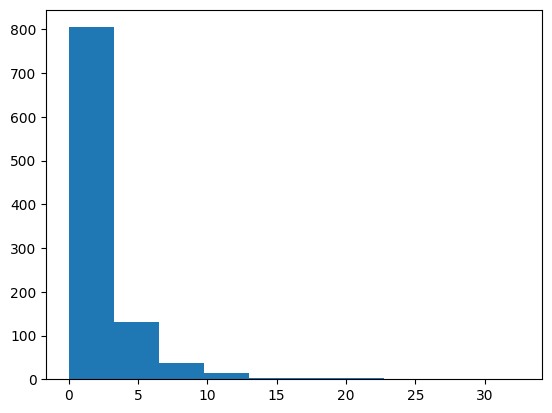

In [24]:
# This third gotcha is annoying.
# But note it only applies when *conditioning* on *equalities*.
# It is totally fine to
# 1) sample transformed variables
# 2) Condition on inequalities of transformed variables
# behold:
x = d.norm(0,1)
y = d.norm(x,1)
z = d.norm(y,1)
y2s = sample(y**2,Given(x**2 <= 1+z**2))
plt.hist(y2s);

# Inference convenience functions
Often you don't want to do raw manipulations of samples.
For this we offer convenience functions:
* `E` - expectations
* `var` - variances
* `cov` - covariances
* `corr` - correlations
* `I` - indicator function
* `P` - probabilities

In [25]:
# very often you draw random variables just to take the mean
x = d.norm(1,1)
y = d.norm(2*x,1)
z = d.norm(2*y,1)
xs,ys,zs=sample([x,y,z])
[np.mean(xs),np.mean(ys),np.mean(zs)]

[1.02311165045, 1.980795514931, 3.9509000998811996]

In [26]:
# In an expectation, the system takes the mean for you
x = d.norm(1,1)
y = d.norm(2*x,1)
z = d.norm(2*y,1)
print('separate',[E(x),E(y),E(z)])
print('together',E([x,y,z])) # more efficient

separate [0.9615394528449999, 1.9854050613010001, 3.9509000998811996]
together [1.02311165045, 1.980795514931, 3.9509000998811996]


In [27]:
# Or it can do the manipulation for the variance
x = d.norm(1,1)
y = d.norm(2*x,1)
z = d.norm(2*y,1)
print('separate',[var(x),var(y),var(z)])
print('together',var([x,y,z])) # more efficient

# This uses the same samples for estimating E(x) and E(x^2) so estimated variance
# is never negative

separate [1.0150357114608592, 5.731303614148819, 22.207501303638676]
together [1.0588157625086831, 5.350695050630479, 22.207501303638676]


In [28]:
# Standard deviation
x = d.norm(1,1)
y = d.norm(2*x,1)
z = d.norm(2*y,1)
print('separate',[std(x),std(y),std(z)])
print('together',std([x,y,z])) # more efficient

separate [1.0074898071250444, 2.394014121543317, 4.712483560039088]
together [1.028987736811612, 2.313156944660366, 4.712483560039088]


In [29]:
# covariance (only works on scalars)
x = d.norm(0,1)
y = d.norm(2*x,1)
cov(x,y)

2.291714567680394

In [30]:
# correlation (only works on scalars)
x = d.norm(0,1)
y = d.norm(2*x,1)
corr(x,y)

0.9095162028258389

In [31]:
# sometimes you might want to compute how often something is true
# this won't work, because y>=x is not a random variable

x = d.norm(0,1)
y = d.norm(x,1)
confused = (y>=x)
print("Expected to fail:")
try:
    E(confused)
except Exception as e:
    print('error:',e)

Expected to fail:
error: 


In [32]:
# instead, you need to use the indicator function
# this transforms the inequality back into a random variable
x = d.norm(0,1)
y = d.norm(x,1)
z = I(y>=x)
E(z)

0.496

In [33]:
# or, you can use P(...) as a shortcut for E(I(...))
x = d.norm(0,1)
y = d.norm(x,1)
P(y>=x)

0.496

In [34]:
# you're still allowed to condition on stuff
x = d.norm(0,1)
y = d.norm(x,1)
z = d.norm(y,1)
P(x>=y,Given(z>=2))

0.122

In [35]:
# The same issue arises with equalities.
# an equality is not a random variable
x = d.bern(0.75)
y = d.bern(0.75)
confused = y==x
print("Expected to fail:")
try:
    E(confused)
except Exception as e:
    print('error:',e)

Expected to fail:
error: 


In [36]:
# But the indicator function turns it back into one
x = d.bern(0.75)
y = d.bern(0.75)
print('E(I(y==x))',E(I(y==x)))
print('P(y==x)   ',P(y==x))

E(I(y==x)) 0.623
P(y==x)    0.622


In [37]:
# here's another example
x = d.bern(0.5)
y = d.bern(t.ifelse(x==0,0.1,0.9))
z = I(y==x)
print(np.mean(sample(z)))
print(E(z))
print(P(x==y))

0.898
0.898
0.898


# Some more examples of things you can do with scalars

In [38]:
# Tverysky and Kehneman's famous 1982 taxicab problem, possibly clearer code
cab_col  = d.bern(0.85)                    # 85% of taxis are green
obs_prob = t.ifelse(cab_col==1, 0.8, 0.2)  # Witnesses are right 80% of the time 
obs_col  = d.bern(obs_prob)                
print('expected',1-12/(12+17))
print('result  ',P(cab_col==1,Given(obs_col==0),niter=10000)) # witness say blue, still probably green

expected 0.5862068965517242
result   0.5862


In [39]:
# the variance of latent variable decreases with more observations
x  = d.norm(0,1)
y1 = d.norm(x,1)
y2 = d.norm(x,1)
y3 = d.norm(x,1)
y4 = d.norm(x,1)
print('var(x)            ',var(x))
print('var(x|y1)         ',var(x,Given(y1==0)))
print('var(x|y1,y2)      ',var(x,Given(y1==0,y2==0)))
print('var(x|y1,y2,y3)   ',var(x,Given(y1==0,y2==0,y3==0)))
print('var(x|y1,y2,y3,y4)',var(x,Given(y1==0,y2==0,y3==0,y4==0)))

var(x)             0.9772913353944256
var(x|y1)          0.5166130956741524
var(x|y1,y2)       0.34440871193838135
var(x|y1,y2,y3)    0.25830649791323895
var(x|y1,y2,y3,y4) 0.20664518009317037


# Basic multivariate random variables

Doing everything with scalars has some major limitations:
* Some things would be painful to represent with scalars
    * Generating a multivariate normal would be annoying
    * Generating something like a Wishart would be REALLY annoying
* Sometimes it's nice to use random variables to index into other random variables
    * E.g. if `i` is a random integer and `x` is a random vector, we'd like to be able to compute things like `E(x[i])`. This is *impossible* if we only work with scalars.
* Only working with scalars means everything is effectively "unrolled" before going into JAGS. This is not very efficient.

In [40]:
# Multivariate Normal
m = [1,-1,2]
C = [[1,.1,.2],[.1,2,.3],[.2,.3,3]]
x = d.mnorm_vcov(m,C) # d.mnorm uses precision parameterization
print('E(x)',E(x))

E(x) [  1.00  -1.02   1.95]


In [41]:
# All scalar->scalar transformation can be vectorized
# This works when:
# 1) All args are scalars
# 2) All args are vectors of the same size
# 3) Some args are scalars and rest are vectors of the same size
m = [1,-1,2]
C = [[1,.1,.2],[.1,2,.3],[.2,.3,3]]
x = d.mnorm_vcov(m,C)
y = d.mnorm_vcov(m,C)
z = d.mnorm_vcov(m,C)
print('E(x)          ',E(x))
print('E(x+1)        ',E(x+1))
print('E(2*x)        ',E(2*x))
print('E(x*y)        ',E(x*y))
print('E(2**x)       ',E(2**x))
print('E(t.sin(x))   ',E(t.sin(x)))

E(x)           [  1.00  -1.02   1.95]
E(x+1)         [  2.00  -0.02   2.95]
E(2*x)         [  1.99  -2.04   3.90]
E(x*y)         [  0.94   1.00   3.90]
E(2**x)        [  2.50   0.81   8.06]
E(t.sin(x))    [  0.53  -0.32   0.20]


In [42]:
### you can subset a vector and then do stuff with those components
m = [1,-1,1]
C = [[1,.1,.2],[.1,2,.3],[.2,.3,3]]
x = d.mnorm_vcov(m,C)
print('E(x0,x1,x2)',E([x[0],x[1],x[2]]))
print('var(x)     ',var(x))
print('cov(x0,x1) ',cov(x[0],x[1]))
print('cov(x0,x2) ',cov(x[0],x[2]))
print('cov(x1,x2) ',cov(x[1],x[2]))
# TODO: cov_matrix

E(x0,x1,x2) [0.9953810342780001, -1.0184116202390001, 0.95224759054]
var(x)      [  0.95   2.00   3.09]
cov(x0,x1)  0.10867333117422995
cov(x0,x2)  0.24782622279256128
cov(x1,x2)  0.3080046773260253


In [43]:
E(x[0])

0.9953810342780001

In [44]:
# Dirichlet
alpha = [1,2,2]
x = d.dirch(alpha)
E(x)

array([  0.20,   0.40,   0.41])

In [45]:
# Multinomial
p = [.1,.2,.7]
k = 5
x = d.multi(p,2)
E(x)

array([  0.18,   0.40,   1.42])

In [46]:
# can also subset vectors using simple slices only
m = [1,2,3,4,5]
C = np.eye(5)
x = d.mnorm_vcov(m,C)
print(E(x[0:3]))
print(E(x[:3]))
print(E(x[2:5]))
print(E(x[2:]))

[  0.95   2.03   3.00]
[  0.95   2.03   3.00]
[  3.00   3.99   4.99]
[  3.00   3.99   4.99]


Functionality with these slices is quite limited
* Only works for 1-D vector (because I'm lazy)
* Slices can't have a step (because I'm lazy)
* Can't use random variables for indices (because that would potentially create non-fixed length vectors)

In [47]:
# you can multiply vectors by vectors (elementwise) or by scalars
x = d.mnorm_vcov([1,2,3],np.eye(3))
y = d.mnorm_vcov([4,5,6],np.eye(3))
a = d.norm(7,1)
print('x*y',E(x*y))
print('a*x',E(a*x))
print('a*y',E(a*y))

x*y [  3.90  10.01  17.94]
a*x [  6.85  13.98  20.93]
a*y [ 27.88  35.01  41.96]


In [48]:
# Wishart
R = [[1,.1,.2],[.1,2,.3],[.2,.3,3]]
k = 4 # must be at least length of R
x = d.wish(R,k)

print('sampled mean')
print(E(x))
print('expected mean')
print(k*np.linalg.inv(np.array(R)))
# the Wishart is often defined in terms of inv(R)

sampled mean
[[  3.84  -0.10  -0.25]
 [ -0.10   1.99  -0.17]
 [ -0.25  -0.17   1.38]]
expected mean
[[  4.07  -0.17  -0.25]
 [ -0.17   2.04  -0.19]
 [ -0.25  -0.19   1.37]]


Currently you can't index 2-D random variables (at all) (because I am lazy)

In [49]:
# you can do matrix multiplication on random variables
# using @ and it behaves similarly to matrix multiplication
# using @ in numpy
# vec @ vec -> scalar
# mat @ vec -> vec
# mat @ mat -> mat

R = np.array([[3,1],[1,2]])
k = 10
X = d.wish(R,k)
U = d.wish(R,k)
y = d.mnorm([4,5],np.eye(2))
z = d.mnorm([6,7],np.eye(2))

print('y @ z')
print(E(y @ z))
print('expected')
print(E(y) @ E(z))

print('X @ y')
print(E(X @ y))
print('expected')
print(E(X) @ E(y)) # because independent

print('z @ X')
print(E(z @ X))
print('expected')
print(E(z) @ E(X))

print('X @ U')
print(E(X @ U))
print('expected')
print(E(X) @ E(U))

y @ z
59.68997220000001
expected
59.29574705963006
X @ y
[  6.30  22.42]
expected
[  6.14  22.29]
z @ X
[ 10.30  30.37]
expected
[ 10.31  30.28]
X @ U
[[ 20.02 -19.79]
 [-19.86  40.16]]
expected
[[ 20.76 -20.27]
 [-20.27  40.08]]


In [50]:
# Here's something that would be really convenient to do
# but you just can't: subset a vector and then condition on it.
# This is a limitation of JAGS. (Section 3.2 of the manual)
m = [0,0,0]
C = [[1,0,0],[0,1,0],[0,0,1]]
x = d.mnorm_vcov(m,C)
    
print("Expected to fail:")
try:
    E(x,Given(x[0]==1))
except Exception as e:
    print('error:',e)

Expected to fail:
error: trying to condition non-conditionable variable: <class 'pangolin.VectorIndex'>


In [51]:
# You can however condition downstream stuff.
m = [0,0,0]
C = [[1,0,0],[0,1,0],[0,0,1]]
x = d.mnorm_vcov(m,C)
y1 = d.norm(x[0],1)
y2 = d.norm(x[1],1)
z = d.mnorm(x[:2],np.eye(2))

print('E(x|y1=10)      ',E(x,Given(y1==10)))
print('E(x|y2=20)      ',E(x,Given(y2==10)))
print('E(x|y1=10,y2=20)',E(x,Given(y1==10,y2==20)))
print('E(x|z=[10,20])  ',E(x,Given(z==[10,20])))

E(x|y1=10)       [  4.93   0.09  -0.05]
E(x|y2=20)       [ -0.08   5.04   0.02]
E(x|y1=10,y2=20) [  5.00  10.09  -0.25]
E(x|z=[10,20])   [  5.00  10.09  -0.25]


# Constructing multivariate random variables

Pangolin does *not* support automatic vectorization of distributions. For example you can't do

`x = d.norm([0,0,0],[1,1,1])`

to create a vector of three standard Gaussian variables.
The reason is:
1. JAGS itself doesn't support this.
2. You could try to build it anyway, but it would be mildly annoying.
3. It leads to lots of subtle errors and very hard to debug code.

Instead, there are a small set of primatives that you can use to *explicitly* create vectorized distributions, hopefully without so much of a chance of confusing yourself.

The first of these is `IID`.

In [52]:
# IID can create vector of variables
x = IID(d.norm(0,1),3) + [0,4,10]
print('E(x)       ',E(x))

E(x)        [  0.05   4.02   9.98]


In [53]:
# you CAN index into vectors using random indices
x = IID(d.norm(0,1),3) + [0,4,10]
i = d.cat([.25,.25,.5])
print('E(x[i]) ',E(x[i]))
print('expected',.25*4 + .5*10)

E(x[i])  6.06678579254
expected 6.0


In [54]:
# but you CAN'T CONDITION on random indices, due to limitation in JAGS
y = d.norm(0,1)
x = IID(d.norm(y,1),3) + [0,4,10]
i = d.cat([.25,.25,.5])

print("expected to fail")
try:
    E(y,Given(x[i]==4))
except Exception as e:
    print('error:',e)

expected to fail
error: trying to condition non-conditionable variable: <class 'pangolin.VectorIndex'>


In [55]:
# Can use IID to create conditional variables
x = d.norm(0,1)
y = IID(d.norm(x,1),4)
print('E(y)            ',E(y))
print('E(y|x=2)        ',E(y,Given(x==2)))
print('E(x|y0=1)       ',E(x,Given(y[0]==1)))
print('E(x|y=[1,2,3,4])',E(x,Given(y==[1,2,3,4])))

E(y)             [ -0.01  -0.00   0.03   0.06]
E(y|x=2)         [  2.04   2.08   1.97   2.04]
E(x|y0=1)        0.5032554614570001
E(x|y=[1,2,3,4]) 2.002058943


In [56]:
# conditioning on parts of a vector
x = d.norm(0,1)
y = IID(d.norm(x,1),4)
print('E(y)            ',E(y))
print('E(y|y0==2)      ',E(y,Given(y[0]==2)))
print('E(y|y0==2,y1==2)',E(y,Given(y[0]==2,y[1]==2)))

E(y)             [ -0.01  -0.00   0.03   0.06]
E(y|y0==2)       [  2.00   1.08   1.04   1.07]
E(y|y0==2,y1==2) [  2.00   2.00   1.36   1.42]


In [57]:
# can use simple slices in a similar way
x = d.norm(0,1)
y = IID(d.norm(x,1),4)
print('E(y)')
print('E(y)            ',E(y))
print('E(y|y0==2)      ',E(y,Given(y[0]==2)))
print('E(y|y0==2,y1==2)',E(y,Given(y[:2]==[2,2])))

E(y)
E(y)             [ -0.01  -0.00   0.03   0.06]
E(y|y0==2)       [  2.00   1.08   1.04   1.07]
E(y|y0==2,y1==2) [  2.00   2.00   1.36   1.42]


In [58]:
# can use IID on vectors: expands first dimension
x = d.mnorm([1,2],np.eye(2))
y = IID(x,4)
E(y)

array([[  1.03,   2.00],
       [  1.02,   1.98],
       [  1.05,   2.03],
       [  0.96,   2.04]])

In [59]:
# you can also use IID recursively
x = d.norm(0,1)
y = IID(x,2)
z = IID(y,3)
a = IID(z,4) + np.arange(24).reshape(4,3,2)
print('a.shape')
print(a.shape)
print('E(a)')
print(E(a))

a.shape
(4, 3, 2)
E(a)
[[[  0.03   0.98]
  [  1.99   3.00]
  [  4.05   5.02]]

 [[  6.01   6.97]
  [  7.96   9.04]
  [  9.99  11.00]]

 [[ 12.02  12.96]
  [ 13.97  14.97]
  [ 16.04  16.97]]

 [[ 18.04  19.01]
  [ 19.99  21.05]
  [ 21.98  23.03]]]


In [60]:
# can condition on that stuff
x = d.norm(0,1)
y = IID(IID(d.norm(x,1),2),3)
E(x,Given(y==[[5,5],[5,5],[5,5]]))

4.28262023

In [61]:
# A more general concept is a vmap
x = vmap(d.norm)([0,1,2],[1,2,3])
print('E(x)  ',E(x))
print('var(x)',var(x))

E(x)   [ -0.02   0.99   1.99]
var(x) [  0.99   0.50   0.35]


In [62]:
# can condition on Vmaps
x = d.norm(0,1)
y = vmap(d.norm)(x*[1,1,1],[1,2,3])
E(x,Given(y==[10,10,10]))

8.56833453

In [63]:
# vmap can also operate on arrays:
# The key is that it consumes the _first_ dimension of each array
u = [[1,2],[3,4],[5,6]]
C = [[[1,0],[0,1]],[[2,0],[0,2]],[[3,0],[0,3]]]
x = vmap(d.mnorm_vcov)(u,C)
print('E(x)')
print(E(x))
print('var(x)')
print(var(x))

E(x)
[[  0.99   1.97]
 [  3.01   3.97]
 [  4.97   6.01]]
var(x)
[[  1.04   0.92]
 [  2.01   2.06]
 [  2.99   3.20]]


In [64]:
# can use IID on top of Vmap
x = vmap(d.norm)([1,2],[1/3,1/4])
y = IID(x,3)
print('E(y)')
print(E(y))
print('var(y)')
print(var(y))

E(y)
[[  0.98   1.94]
 [  1.01   1.96]
 [  0.97   2.01]]
var(y)
[[  3.13   3.69]
 [  3.01   4.11]
 [  2.99   4.26]]


In [65]:
# can condition on IID on top of Vmap
x = d.norm(0,1)
y = vmap(d.norm)(x*[1,1],[1/3,1/4])
z = IID(y,3)
print('E(y)')
print(E(y))
print('var(y)')
print(var(y))
print('E(x|z=[[1,1],[1,1],[1,1]])')
print(E(x,Given(z==[[1,1],[1,1],[1,1]])))

E(y)
[ -0.05  -0.04]
var(y)
[  3.82   5.28]
E(x|z=[[1,1],[1,1],[1,1]])
0.63142747129


# General vectorization

In [66]:
# The major construction for making things efficient in Pangolin is Vmap
x = d.mnorm_vcov([1,2,3],.05*np.eye(3))
y = vmap(t.pow,[True,False])(x,2)
E(y)

array([  1.04,   4.03,   9.03])

In [67]:
x = IID(d.mnorm_vcov([1,2,3],.05*np.eye(3)),3)
vpow = vmap(t.pow,[True,False])
vpow2 = vmap(vpow,[True,False])
y = vpow2(x,2)

#y = Vmap(t.pow,[True,False])(x,2)
E(y)

array([[  1.06,   4.07,   9.03],
       [  1.05,   4.00,   9.07],
       [  1.03,   4.02,   9.04]])

In [68]:
E(y,Given(x==np.ones([3,3])))

array([[  1.00,   1.00,   1.00],
       [  1.00,   1.00,   1.00],
       [  1.00,   1.00,   1.00]])